In [758]:
#AIM : PREDICT THE STOCK PRICE FOR THE NEXT THREE MONTHS FOR AMAZON

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pandas.plotting import register_matplotlib_converters
from time import time
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
register_matplotlib_converters()

# Importing plotly and cufflinks in offline mode
import plotly.express as px
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [759]:
# READING DATASET
df = pd.read_csv('Amazon.csv')

In [760]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,312.579987,314.750000,306.959991,308.519989,308.519989,2783200
1,2015-01-05,307.010010,308.380005,300.850006,302.190002,302.190002,2774200
2,2015-01-06,302.239990,303.000000,292.380005,295.290009,295.290009,3519000
3,2015-01-07,297.500000,301.279999,295.329987,298.420013,298.420013,2640300
4,2015-01-08,300.320007,303.140015,296.109985,300.459991,300.459991,3088400


In [761]:
df['Date'] = pd.to_datetime(df.Date)

In [762]:
#set date as index
df.set_index('Date', inplace=True)

In [763]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,312.579987,314.750000,306.959991,308.519989,308.519989,2783200
2015-01-05,307.010010,308.380005,300.850006,302.190002,302.190002,2774200
2015-01-06,302.239990,303.000000,292.380005,295.290009,295.290009,3519000
2015-01-07,297.500000,301.279999,295.329987,298.420013,298.420013,2640300
2015-01-08,300.320007,303.140015,296.109985,300.459991,300.459991,3088400


In [764]:
df.shape

(1761, 6)

In [769]:
# FUNCTIONS TO PLOT COLUMNS AND REMOVE MISSING VALUES
def plot_col(stk, lbl='Column val'):
    plt.figure(figsize=(10,4))
    plt.plot(stk)
    plt.title(lbl)
    plt.ylabel('Stock Price')
    plt.xlabel('Year')
    for year in range(2015,2023):
        plt.axvline(str(year)+'-01-02', color = 'gray', linestyle='--')
        
    plt.savefig(lbl+'.png')
    plt.show()
    
def missing_values(df):
    # ARRANGE MISSING VALUES IN A
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)  # count() only counts the non-NA values, therefore we first use isnull to include all the values (false and true), then count()
    #print(pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent']))
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

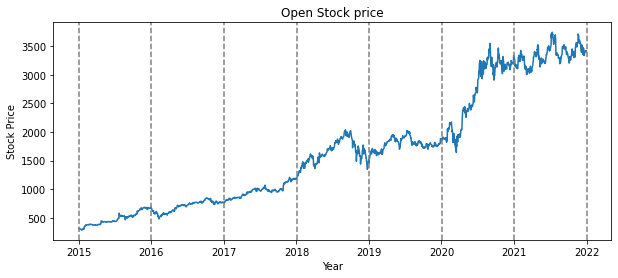

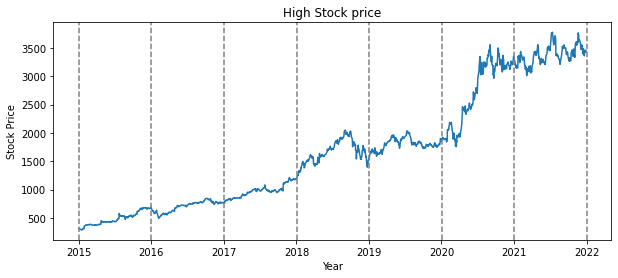

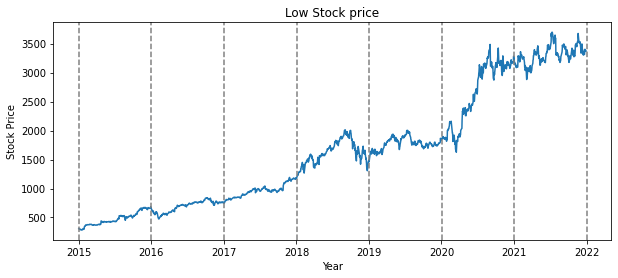

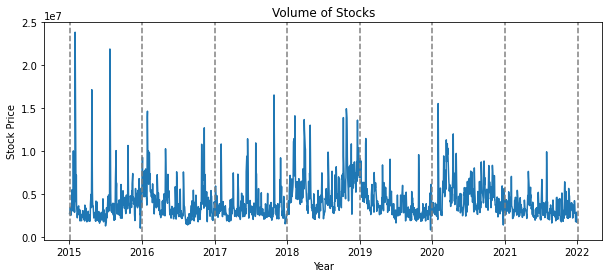

In [770]:
# CHECKING EACH COLUMN VALUES

plot_col(df.Open,lbl='Open Stock price')
plot_col(df.High,lbl='High Stock price')
plot_col(df.Low,lbl='Low Stock price')
plot_col(df.Volume,lbl='Volume of Stocks')


In [771]:
df = df[['Close']]

In [772]:
df.head()

,Close
Date,
2015-01-02,308.519989
2015-01-05,302.190002
2015-01-06,295.290009
2015-01-07,298.420013
2015-01-08,300.459991


In [773]:
# RE-SAMPLING DATA TO 1 MONTH

df_mon = df.resample(rule='1M').mean()


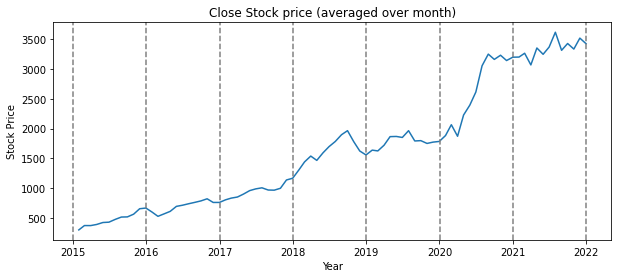

In [774]:
plot_col(df_mon.Close,lbl='Close Stock price (averaged over month)')

<AxesSubplot:ylabel='Density'>

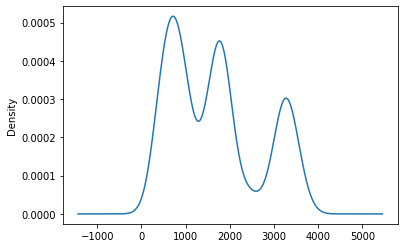

In [775]:
# Visualising distribution with a Kernel Density estimate (draws a gaussian around each point for smooth histogram)

df.Close.plot(kind='kde')

In [777]:
# Looking at the time-series, it is clearly not stationary,

# To give a quantitative proof of it, we perform the ADF test

# Performing an Augmented_Dickey_Fuller Test (along with plottin rolling mean)

# IF P-VALUE IS LESS THAN 0.05 : REJECT NULL HYPOTHESIS, THAT MEANS THE DATA IS STATIONARY

def perform_adf_test(series,yval=''):
    rolling_mean = series.rolling(12).mean()
    rolling_std = series.rolling(12).std()
    plt.plot(series,color='blue',label='Original Series')
    plt.plot(rolling_mean,color='red',label='Rolling Mean')
    plt.plot(rolling_std,color='black',label='Rolling Std')
    plt.xlabel('Years')
    plt.ylabel('%s Stock price'%yval)
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.savefig('ADF_test.png')
    plt.show(block=False)
    adf_result = adfuller(series)
    adf_lbls = pd.Series(adf_result[0:4], index=['Test Statistics','p-value','No. of Lags used','No. of observations used'])
    print(adf_lbls)
    print('ADF Statistic: %f' % adf_result[0])
    print('p-value: ', adf_result[1])


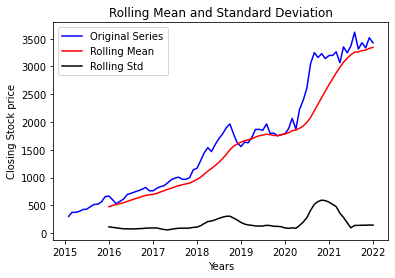

Test Statistics              0.526567
p-value                      0.985659
No. of Lags used             8.000000
No. of observations used    75.000000
dtype: float64
ADF Statistic: 0.526567
p-value:  0.985658584095752


In [778]:
perform_adf_test(df_mon.Close,'Closing')

In [779]:
#Since the p-value is more than 0.05 (also, we can see that the mean and standard deviation are increasing), our series is not stationary! 

<Figure size 432x288 with 0 Axes>

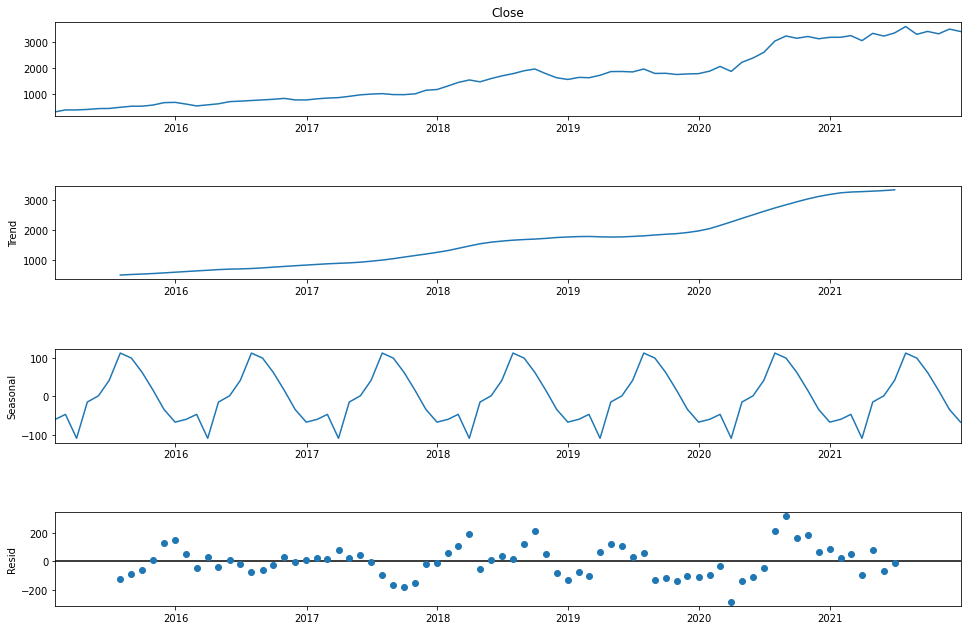

In [780]:
# Therefore, I need to remove the seasonality and trends from this time-series, before proceeding

# Decompose the series to take a look at the trend and seasonality:

decomp_series = seasonal_decompose(df_mon.Close,model = 'additive')
fig = plt.figure()
fig = decomp_series.plot()
fig.set_size_inches(15,10)
plt.savefig('Decomposition.png')

In [781]:
# To make the series stationary:

# STEP1 : Perform LOG: LOG removes increasing variance in the data

df_mon['Close_log'] = np.log(df_mon.Close)


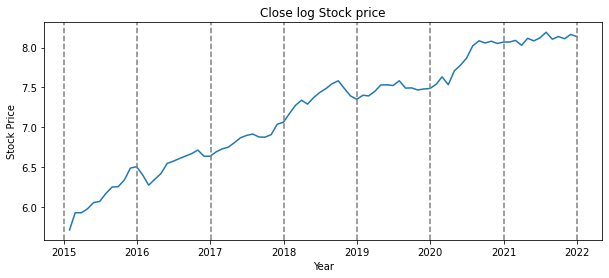

In [782]:
plot_col(df_mon.Close_log,lbl='Close log Stock price')

In [783]:
# Two methods to remove the trend in the time-series

# Method 1: 1st difference: Subtracting 1 lag

df_mon['Close_1diff'] = df_mon.Close_log.diff()[1:]

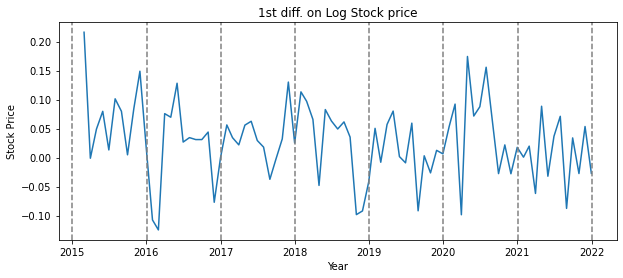

In [784]:
plot_col(df_mon.Close_1diff,lbl='1st diff. on Log Stock price')

Text(0, 0.5, '1st diff. of Log of Closing Stock Price')

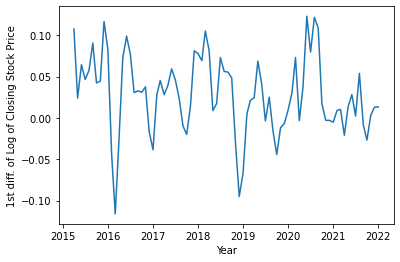

In [785]:
# Also checking both rolling mean of this 1st difference time series:

plt.plot(df_mon.Close_1diff.rolling(window = 2).mean())
plt.xlabel('Year')
plt.ylabel('1st diff. of Log of Closing Stock Price')

In [786]:
# DROP MISSING VALUES IF ANY
df_mon = df_mon.dropna()

<Figure size 432x288 with 0 Axes>

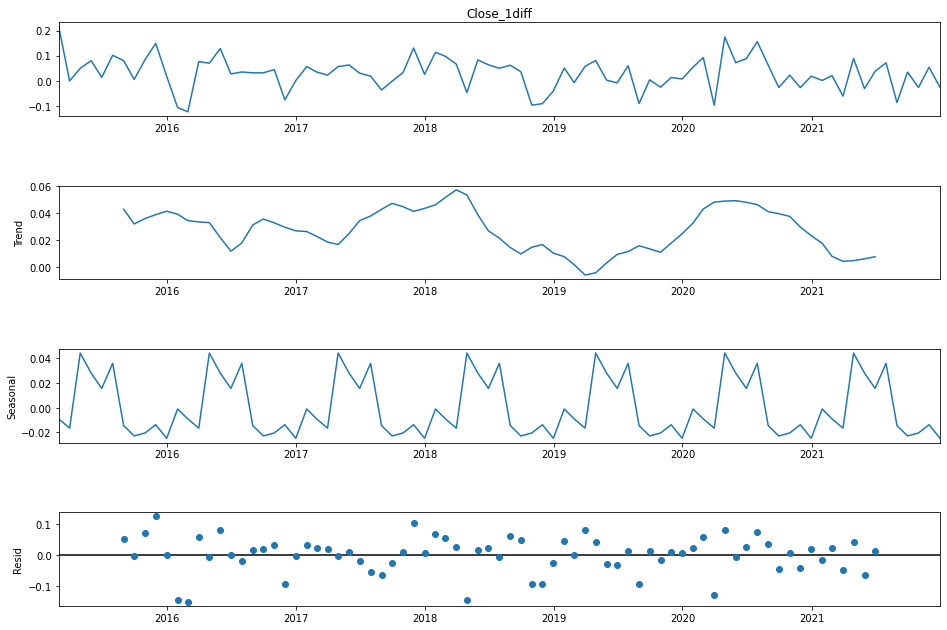

In [787]:
# Checking with decomposition

decomp_series = seasonal_decompose(df_mon.Close_1diff,model = 'additive')
fig = plt.figure()
fig = decomp_series.plot()
fig.set_size_inches(15,10)


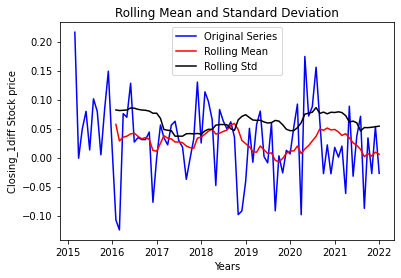

Test Statistics            -8.640603e+00
p-value                     5.439213e-14
No. of Lags used            0.000000e+00
No. of observations used    8.200000e+01
dtype: float64
ADF Statistic: -8.640603
p-value:  5.4392129902309154e-14


In [788]:
perform_adf_test(df_mon.Close_1diff,'Closing_1diff')

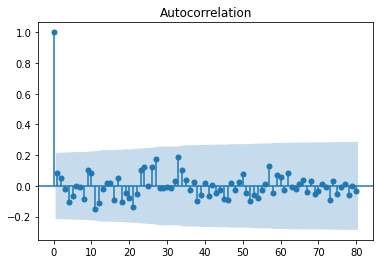

In [789]:
# P-value is less than 0.05, thus 1-difference after log seems to be enough to make a stationary time-series here

# Proceed to make a correlogram i.e. apply ACF and PACF


acf_plot = plot_acf(df_mon.Close_1diff,lags = 80)

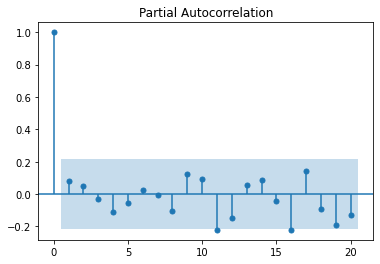

In [790]:
pacf_plot = plot_pacf(df_mon.Close_1diff)

In [791]:
# Method 2: Subtract the moving average to remove this trend

moving_avg = df_mon.Close_log.rolling(window = 2).mean()


In [792]:
df_mon['Close_sub_avg'] = df_mon.Close_log - moving_avg

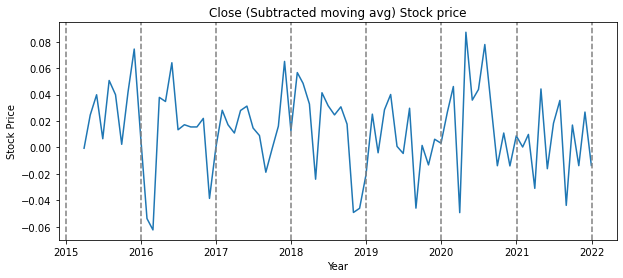

In [793]:
plot_col(df_mon.Close_sub_avg,lbl='Close (Subtracted moving avg) Stock price')

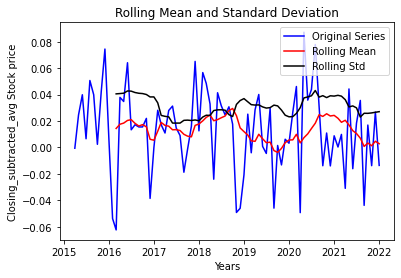

Test Statistics            -7.932666e+00
p-value                     3.479422e-12
No. of Lags used            0.000000e+00
No. of observations used    8.100000e+01
dtype: float64
ADF Statistic: -7.932666
p-value:  3.4794215065651308e-12


In [794]:
df_mon = df_mon.dropna()
perform_adf_test(df_mon.Close_sub_avg,'Closing_subtracted_avg')

In [795]:
# All the seasonality and trend have been successfully removed from the time-series.
# Subtracting Moving average method gives a similarly small p-value. 

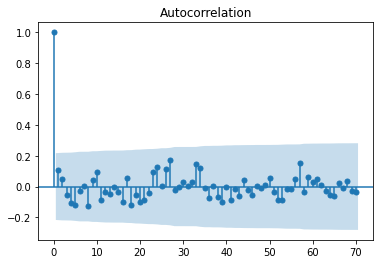

In [796]:
# Plotting the ACF : Auto Correlation Function
# 1st line is corr of y with lag1
# 2nd line is corr of y with lag2 (including contributions from both 1 and 2)
# If there exist a seasonal pattern in the series, there will be a repetetive pattern in the ACF
# Blue shaded region includes statistically insignificant relationships and outside are significant ones

# Lags of the series are how many units before from that are calculated 
acf_plot = plot_acf(df_mon.Close_sub_avg,lags = 70)



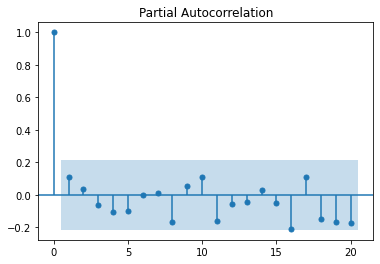

In [797]:
pacf_plot = plot_pacf(df_mon.Close_sub_avg)

In [798]:
# Lag of MA model (monthly) comes from ACF:
# 2nd diff: 
#                    Non-Seasonal: 1
#                    Seasonal: 0

# Lag of AR model (monthly) comes from PACF:
# 2nd diff: 
#                    Non-Seasonal: 2
#                    Seasonal: 0


# Lag of MA model (monthly) comes from ACF:
# sub moving avg: 
#                    Non-Seasonal: 3
#                    Seasonal: 0

# Lag of AR model (monthly) comes from PACF:
# sub moving avg: 
#                    Non-Seasonal: 1
#                    Seasonal: 3


In [799]:
# - Created correlograms with both time series using ACF and PACF to determine the significant lags
# - Time series with Method 1: 
# 	- Found Significant lag at 11 months and 16 months in PACF
# 		- Implies AR model can be used to fit the data
# - Time series with Method 2:
# 	- Found significant lag at 16 months in PACF
# 	- Implies AR model can be used to fit the data

In [800]:
# First looking at ARIMA model 

split = int(0.8*len(df_mon))

# Since ARIMA needs a stationary time-series, I am giving logged time-series to train the model, it will do differencing itself.
train_data = df_mon[:split+1].Close_log
test_data = df_mon[split:].Close_log

# Lag of 16, with 1 order of differencing

model_ar = ARIMA(train_data, order = (16,1,0))
start = time()
model_ar_fit = model_ar.fit()
end = time()
print('Time took for the ARIMA model to run: %f s'%(end - start))
print(model_ar_fit.summary())

/home/tasha/.local/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




Time took for the ARIMA model to run: 145.904529 s
                             ARIMA Model Results                              
Dep. Variable:            D.Close_log   No. Observations:                   65
Model:                ARIMA(16, 1, 0)   Log Likelihood                  94.064
Method:                       css-mle   S.D. of innovations              0.055
Date:                Thu, 19 Oct 2023   AIC                           -152.129
Time:                        15:44:45   BIC                           -112.990
Sample:                    04-30-2015   HQIC                          -136.686
                         - 08-31-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0311      0.006      5.380      0.000       0.020       0.042
ar.L1.D.Close_log      0.2497      0.125      1.996     

In [801]:
# Looking at the p-value of lags, we see LAG of 11 months is the only significant lag here.

Normalised RMSE from ARIMA model is:  0.06387886202908148


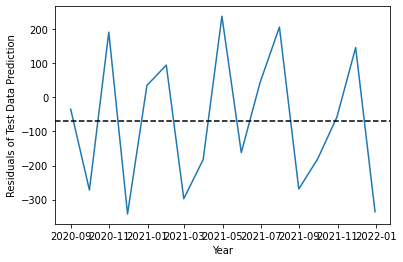

In [802]:
# PREDICTION FROM TEST DATA

# Re-defining the data to plot

train_data_plot = df_mon[:split+1].Close
test_data_plot = df_mon[split:].Close
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

predictions = model_ar_fit.predict(start = pred_start_date, end = pred_end_date)

pred_rev=[]

# Inverse-transforming the differencing and log for predictions to plot
for i in range(0,len(predictions)):
    prev_point = df_mon.Close_log[split+i-1]
    pred_rev.append(predictions[i] + prev_point)

pred_rev = [np.exp(p) for p in pred_rev]

# Check residuals distribution (test_data = actual, prediction = from model)
residuals = test_data_plot - pred_rev
rmse_var = []

# Calculating the RMSE 
for p in range(len(pred_rev)):
    #print(pred_rev[p])
    rmse_var.append((pred_rev[p] - test_data_plot[p])**2)
rmse =  np.sqrt(np.sum(rmse_var)/len(pred_rev))/(np.max(df_mon.Close) - np.min(df_mon.Close))
print('Normalised RMSE from ARIMA model is: ',rmse)

# Plot the residuals
plt.plot(residuals)
plt.ylabel('Residuals of Test Data Prediction')
plt.xlabel('Year')
plt.axhline(residuals.mean(),linestyle = '--', color = 'k')

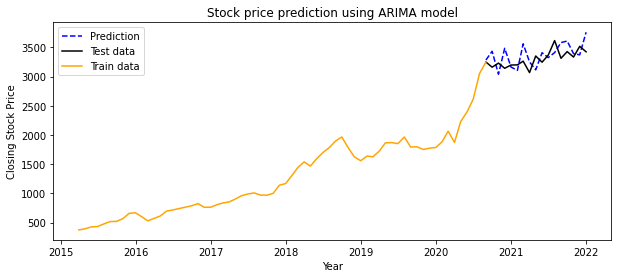

In [803]:
# Plotting non-transformed train and test data 

plt.figure(figsize = (10,4))
plt.plot(test_data_plot.index,pred_rev,label='Prediction',linestyle='--',color='blue')
plt.plot(test_data_plot,label='Test data', color='black')
plt.plot(train_data_plot,label='Train data',color='Orange')
plt.xlabel('Year')
plt.ylabel('Closing Stock Price')
plt.title('Stock price prediction using ARIMA model')
plt.legend()
plt.savefig('Stock prediction ARIMA model.png')
plt.show()

In [804]:
# IMPLEMENTING AUTO ARIMA MODEL, Since we also see seasonality, we will use seasonal differencing and a seasonal model

import six
import sys
import joblib

sys.modules['sklearn.externals.joblib'] = joblib
sys.modules['sklearn.externals.six'] = six
from pyramid.arima import auto_arima


In [805]:
# Splitting train and test data set
split = int(0.8*len(df_mon))
train_data = df_mon[:split].Close_log
test_data = df_mon[split:].Close_log

stepwise_model = auto_arima(train_data,start_p = 0, start_P = 0, D = 1, m=12,seasonal = True,
                        trace = True, suppress_warnings = True)

print(stepwise_model.aic())
stepwise_model.fit(train_data)

Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=-106.863, BIC=-97.107, Fit time=0.913 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-97.787, BIC=-93.885, Fit time=0.056 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-109.532, BIC=-101.727, Fit time=0.800 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-108.766, BIC=-100.961, Fit time=0.987 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-98.555, BIC=-92.701, Fit time=0.114 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=-108.341, BIC=-98.585, Fit time=2.002 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=-108.204, BIC=-98.448, Fit time=1.157 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=-106.518, BIC=-94.810, Fit time=1.670 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-110.157, BIC=-104.303, Fit time=0.442 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True)

In [806]:
#Best model: (0,1,0)(1,1,0,12)

predictions,confint = stepwise_model.predict(n_periods=17, return_conf_int = True, alpha = 0.2)

Text(0, 0.5, 'Residuals from Auto Arima')

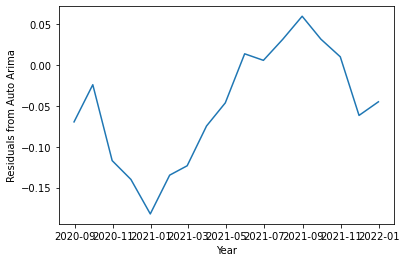

In [807]:
# Since the residuals have huge decrease in the variation, this model is better than the previous one.
residuals = predictions - test_data
plt.plot(residuals)
plt.xlabel('Year')
plt.ylabel('Residuals from Auto Arima')

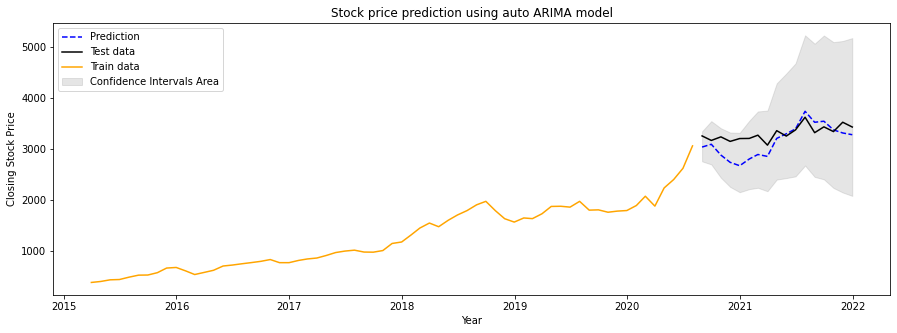

In [808]:
# Predicting over test data set

split = int(0.8*len(df_mon))
train_data_plot = df_mon[:split].Close
test_data_plot = df_mon[split:].Close
confint_transformed = [np.exp(c) for c in confint]
cf = pd.DataFrame(confint_transformed)
# Inverse-transforming the differencing and log for predictions to plot
pred_rev = []
# for i in range(0,len(future_forecast)):
#     prev_point = df_mon.Close_log[split+i-1]
#     pred_rev.append(predictions[i] + prev_point)
pred_rev = [np.exp(p) for p in predictions]

prediction_series = pd.Series(pred_rev, index = test_data_plot.index)

plt.figure(figsize = (15,5))
plt.plot(test_data_plot.index, pred_rev,label='Prediction',linestyle='--',color='blue')
plt.fill_between(test_data_plot.index,
                cf[0],
                cf[1],color='grey',alpha=.2, label='Confidence Intervals Area')
plt.plot(test_data_plot,label='Test data',color='black')
plt.plot(train_data_plot,label='Train data',color='orange')
plt.xlabel('Year')
plt.ylabel('Closing Stock Price')
plt.title('Stock price prediction using auto ARIMA model')
plt.savefig('Stock price prediction with auto ARIMA model.png')
#plt.plot(residuals,label='resids')
plt.legend(loc="upper left")

In [809]:
# To fit for seasonality, let's implement SARIMA model

# Splitting train and test data set

split = int(0.8*len(df_mon))
train_data = df_mon[:split].Close
test_data = df_mon[split:].Close

In [810]:
# Looking at PACF closely, it appears there might be a 4 month seasonality:

model = SARIMAX(train_data, order = (0,1,0), seasonal_order=(1,1,0,12))

In [811]:
start = time()
model_fit = model.fit()
end = time()
print('Time took for the SARIMA model to run: %f s'%(end - start))

Time took for the SARIMA model to run: 0.186987 s


In [812]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                   65
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -322.997
Date:                            Thu, 19 Oct 2023   AIC                            649.994
Time:                                    15:49:43   BIC                            653.897
Sample:                                03-31-2015   HQIC                           651.490
                                     - 07-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5203      0.135     -3.842      0.000      -0.786      -0.255
sigma2      1.356e+04   2123.341   

In [813]:
#Only upto lag 4 or 5 are significant

In [814]:
# get prediction by simply inputing the times that I want to predict for

pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]


In [815]:
predictions = model_fit.predict(start = pred_start_date, end = pred_end_date)

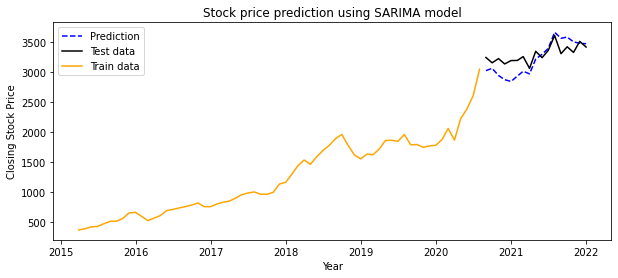

In [816]:

plt.figure(figsize = (10,4))
plt.plot(predictions,label='Prediction',linestyle='--',color='blue')
plt.plot(test_data,label='Test data',color='black')
plt.plot(train_data,label='Train data',color='orange')
plt.xlabel('Year')
plt.ylabel('Closing Stock Price')
plt.title('Stock price prediction using SARIMA model')
#plt.plot(residuals,label='resids')
plt.legend()

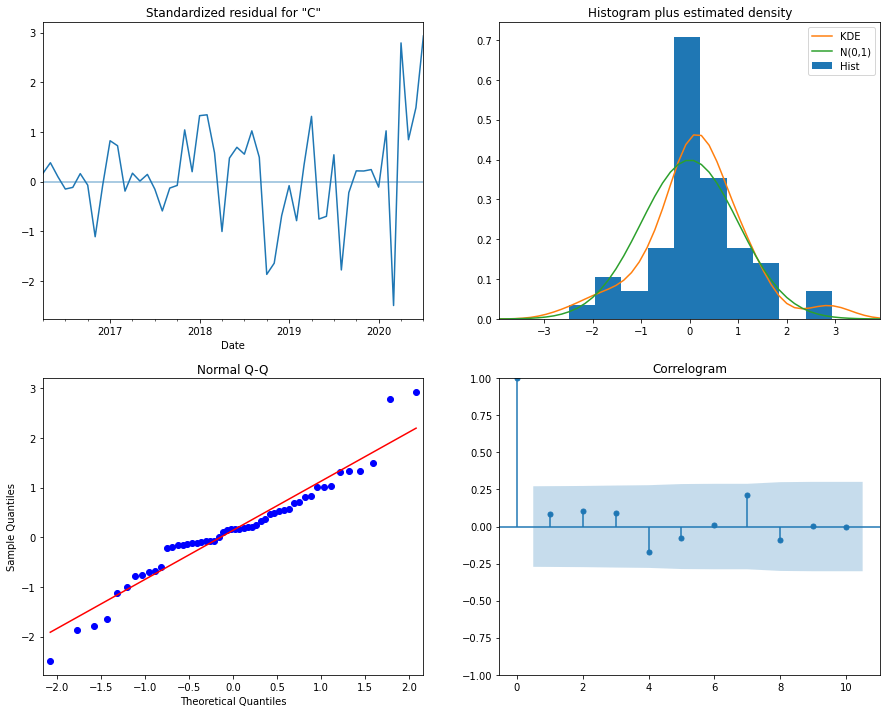

In [817]:
model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

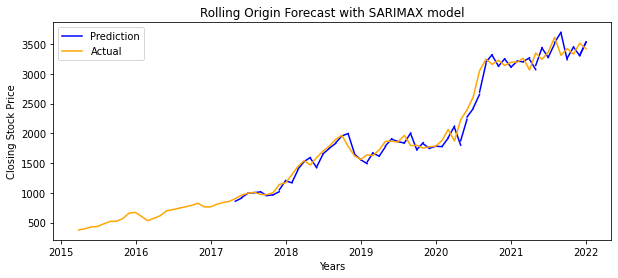

In [818]:
# Trying Rolling Forecast for every month with SARIMAX model

# split = int(0.8*len(df_mon))
all_data = df_mon.Close
plt.figure(figsize = (10,4))
#plt.plot(train_data,label='train', color='black')
for end in range(25,len(df_mon)-1):
    train_data = df_mon[:end+1].Close
    test_data = df_mon[end:end+2].Close
    model = SARIMAX(train_data, order = (1,1,0), seasonal_order=(1,0,0,12))
    model_fit = model.fit()
    pred_start_date = test_data.index[0]
    pred_end_date = test_data.index[-1]
    predictions = model_fit.predict(start = pred_start_date, end = pred_end_date)
    #Check how are residuals (test_data = actual, prediction = is pred from model)
    residuals = test_data - predictions
    plt.plot(predictions,color='blue')
    #plt.plot(train_data,label='train', color='black')

plt.plot(predictions,label='Prediction',color='blue')
#plt.plot(predictions,label='pred',color='blue')
plt.title('Rolling Origin Forecast with SARIMAX model')
plt.plot(all_data,label='Actual',color='orange')
plt.xlabel('Years')
plt.ylabel('Closing Stock Price')
plt.legend()
plt.savefig('Rolling Origin Forecast with SARIMA model.png')
plt.show()




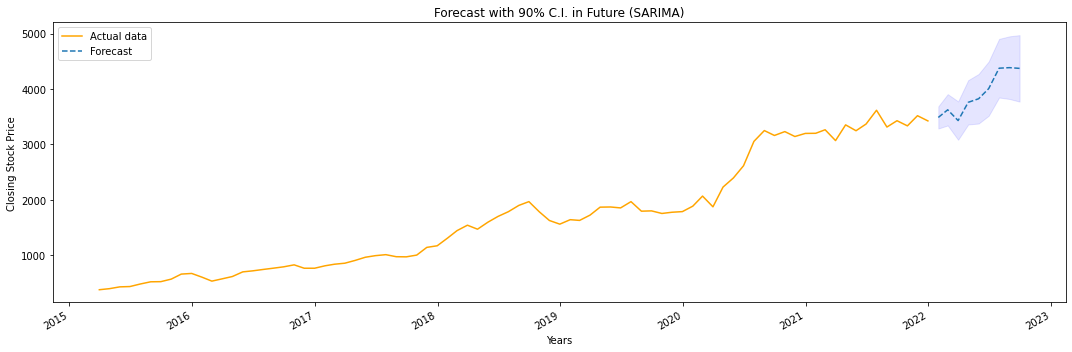

In [819]:
# Forecast of stock price in future with Sarima model, trained model on all data
split = int(0.80*len(df_mon))
train_data = df_mon[:split].Close
test_data = df_mon[split:].Close
all_data = df_mon.Close
model = SARIMAX(all_data, order = (0,1,0), seasonal_order=(1,1,0,12))
model_fit = model.fit()

# Plot forecast
fig, ax = plt.subplots(figsize=(15, 5))  
ax.plot(all_data,label='Actual data',color='orange')
# Construct the forecasts with 90% Confidence Interval
fcast = model_fit.get_forecast('2022-09-30').summary_frame(alpha=0.1)
#print(fcast)
fcast['mean'].plot(ax=ax, style='--',label='Forecast')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='blue', alpha=0.1) 
plt.xlabel('Years')
plt.ylabel('Closing Stock Price')
plt.title('Forecast with 90% C.I. in Future (SARIMA)')
plt.legend(loc='upper left')
fig.tight_layout()
plt.savefig('Forecast.png')
plt.show()